In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, \
    precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks

from model import ml_models

In [2]:
# Modify the Hyper parameters
########################################################################################################################
# Modify to change the ratio of training and test data set
HPtest_size = 0.25
HPvalidation_size = 0.25

# Modify to change the features to be used as independent features
HPfrom_x = 0  # 0th index as the first feature, from_x is an inclusive index
HPto_y = 8  # 8th index as the last feature, to_y is an exclusive index

# Modify to change the depth limit for the Decision Tree model
HPmax_depth = 10
depth_range = range(1, HPmax_depth + 11)
# Modify the split limit for the Decision Tree model
HPmin_samples_split = 2

# Modify to change the solver for the Logistic Regression model
solver_options = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
HPsolver = solver_options[1]

# Modify to change the maximum iteration for Logistic Regression model
HPmax_iter = 1000

# Modify to change the number of folds for cross validation
HPk_folds = 10

# Modify to change the scoring metric for cross validation
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']
HPscoring = scoring_metrics[0]

# Modify whether to standardize or normalize the data
HPscale = ['standardize', 'normalize', None]
scaler = HPscale[2]

# Modify for resampling techniques
resampling_options = ['none', 'SMOTE', 'TomekLinks', 'RandomUnderSampler', 'RandomOverSampler']
HPresampling = resampling_options[0]
########################################################################################################################

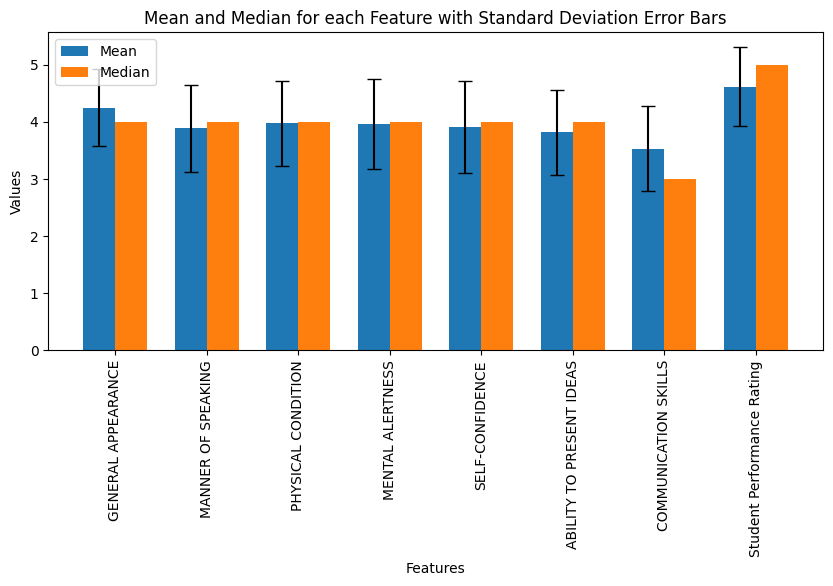

CLASS
1    1729
0    1253
Name: count, dtype: int64
Proportion of Employable Students: 57.98%
Proportion of Less Employable Students: 42.02%


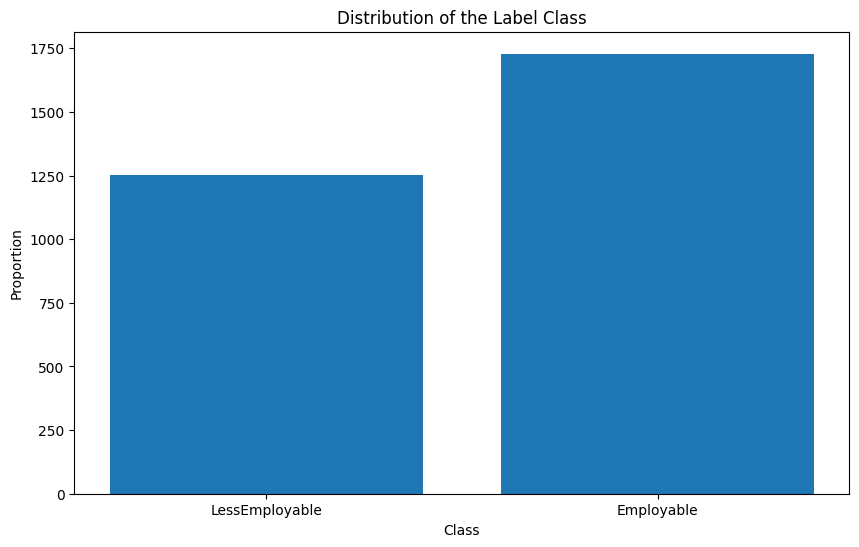

In [3]:
# Check if normalization or standardization is required
if scaler == 'standardize':
    scaler = StandardScaler()
elif scaler == 'normalize':
    scaler = MinMaxScaler()

# Check if resampling is required
if HPresampling == 'SMOTE':
    resampler = SMOTE()
elif HPresampling == 'TomekLinks':
    resampler = TomekLinks()
elif HPresampling == 'RandomUnderSampler':
    resampler = RandomUnderSampler()
elif HPresampling == 'RandomOverSampler':
    resampler = RandomOverSampler()

data = pd.read_csv('dataset/Student-Employability-Datasets.csv')
data = data.drop(['Name of Student'], axis=1)

# instantiate label encoder object to encode the target variable
le = LabelEncoder()

# Map the target variables appropriately
data['CLASS'] = data['CLASS'].map({'LessEmployable': 0, 'Employable': 1})

# Get the independent features
X = data.iloc[:, HPfrom_x:HPto_y]
columns = X.columns

# Get the dependent features
y = data.iloc[:, -1]

# Encode the target variable
y = le.fit_transform(y)

# Calculate the mean, median and standard deviation for each feature
summary_stats = (X.describe().loc[['mean', 'std']]).T
medians = X.median()
summary_stats['median'] = medians
# Save the summary statistics to a CSV file
summary_stats.to_csv('summary_stats.csv', index=True)

# Load the summary statistics from the CSV file
summary_stats = pd.read_csv('summary_stats.csv', index_col=0)

# Create a grouped bar chart showing the mean and median for each feature with error bars for the standard deviation
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(summary_stats.index))

plt.bar(x - bar_width/2, summary_stats['mean'], width=bar_width, yerr=summary_stats['std'], capsize=5, label='Mean')
plt.bar(x + bar_width/2, summary_stats['median'], width=bar_width, label='Median')

plt.xticks(x, summary_stats.index, rotation=90)
plt.subplots_adjust(bottom=0.35)
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Mean and Median for each Feature with Standard Deviation Error Bars')
plt.legend()
plt.show()

# Calculate the distribution of the label class
class_distribution = data['CLASS'].value_counts()
print(class_distribution)
print('Proportion of Employable Students: {:.2f}%'.format(class_distribution[1]/len(data)*100))
print('Proportion of Less Employable Students: {:.2f}%'.format(class_distribution[0]/len(data)*100))
# Create a bar chart showing the distribution of the label class
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.index, class_distribution.values)
plt.xticks(class_distribution.index, ['Employable', 'LessEmployable'])
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.title('Distribution of the Label Class')
plt.show()

if scaler:
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=HPtest_size, random_state=42)

# Split for validation of decision tree model
# Create a validation dataset from the training data
_, X_val, _, y_val = train_test_split(X_train, y_train, test_size=HPvalidation_size, random_state=42)

# Check if resampling is required
if HPresampling != 'none':
    X_train, y_train = resampler.fit_resample(X_train, y_train)

# Create the logistic regression model
LR_model = ml_models.SimpleLogicalRegression(X=X_train, y=y_train,
                                             solver=HPsolver, max_iter=HPmax_iter)

# create the decision tree model
DT_model = ml_models.DecisionTreeModel(X_train, y_train, max_depth=HPmax_depth,
                                       criterion='gini', min_samples_split=HPmin_samples_split)

# cross validate the models before training
lr_cv_scores, dt_cv_scores = {}, {}

for metric in scoring_metrics:
    lr_cv_scores[metric], dt_cv_scores[metric] = ml_models.get_cv_score(LR=LR_model.get_model(),
                                                                        DT=DT_model.get_model(),
                                                                        X=X_train, y=y_train,
                                                                        cv=HPk_folds, scoring=metric)


# Train the model
LR_model.train()
DT_model.train()

# Predict the test data for both models
y_pred_LR = LR_model.predict(X_test)
y_pred_DT = DT_model.predict(X_test)

# Calculate the scores for Logistic Regression
lr_accuracy = accuracy_score(y_test, y_pred_LR)
lr_precision = precision_score(y_test, y_pred_LR)
lr_recall = recall_score(y_test, y_pred_LR)
lr_f1 = f1_score(y_test, y_pred_LR)
lr_cm = confusion_matrix(y_test, y_pred_LR)

# Calculate the scores for Decision Tree
dt_accuracy = accuracy_score(y_test, y_pred_DT)
dt_precision = precision_score(y_test, y_pred_DT)
dt_recall = recall_score(y_test, y_pred_DT)
dt_f1 = f1_score(y_test, y_pred_DT)
dt_cm = confusion_matrix(y_test, y_pred_DT)

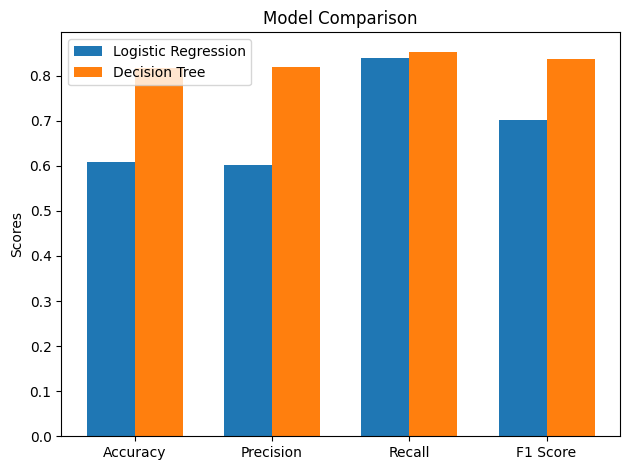

In [4]:
# Create a bar chart to compare the two models
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
logistic_scores = [lr_accuracy, lr_precision, lr_recall, lr_f1]
decision_tree_scores = [dt_accuracy, dt_precision, dt_recall, dt_f1]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, logistic_scores, width, label='Logistic Regression')
rects2 = ax.bar(x + width / 2, decision_tree_scores, width, label='Decision Tree')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

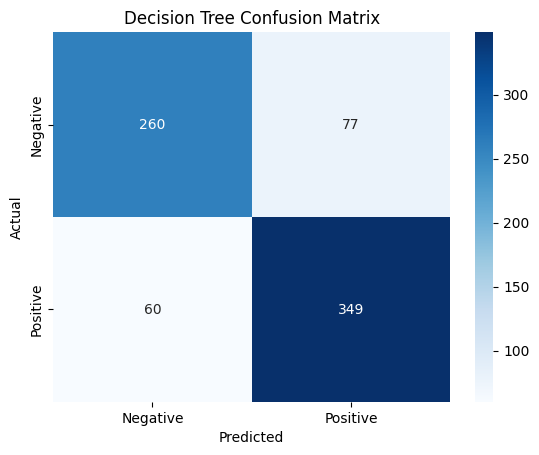

In [5]:
# add the confusion matrix for the decision tree model
sns.heatmap(dt_cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()

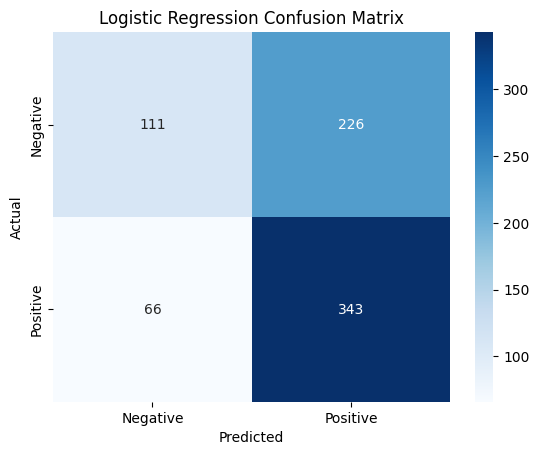

In [6]:
# add the confusion matrix for the logistic regression model
sns.heatmap(lr_cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

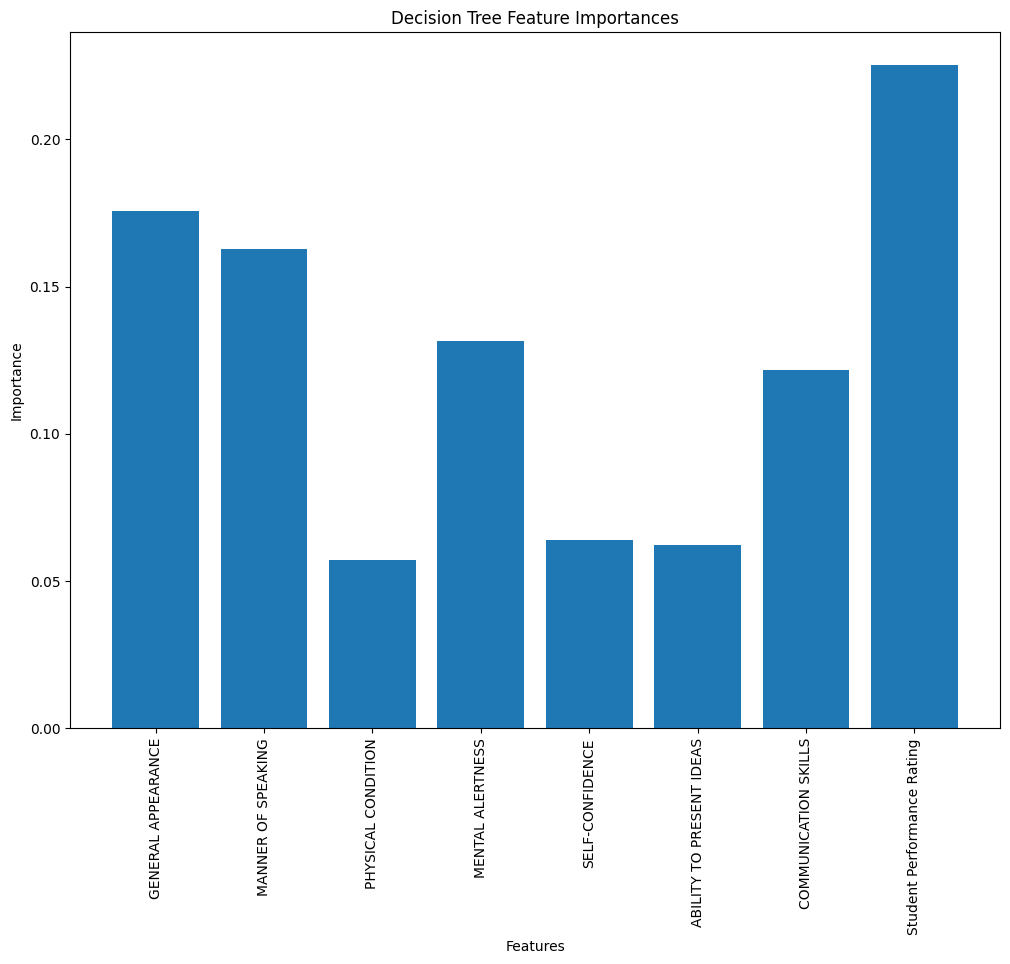

In [7]:
# Generate graphs for decision tree (Decision Tree visualization and Feature Importance)
DT_model.generate_decisiontree_graph()
DT_model.graph_feature_importances()

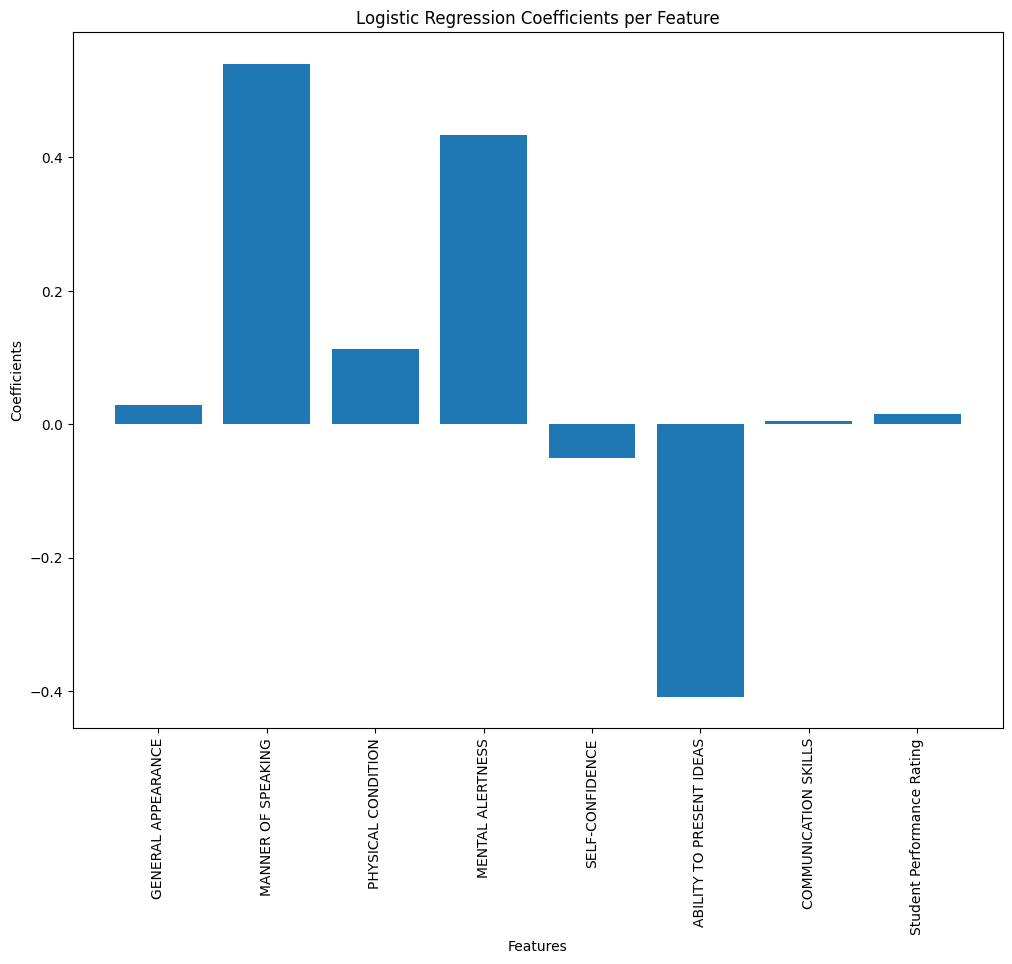

In [8]:
# Generate graphs for logistic regression (Logistic Regression visualization)
LR_model.plot_coefficients()

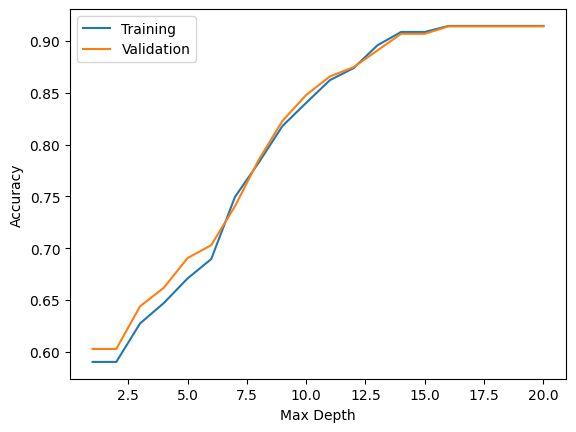

In [9]:
# check for underfitting or overfitting max depth for decision tree
# Create lists to store the training and validation accuracy scores
train_acc = []
val_acc = []

# Loop over the max_depth values
for max_depth in depth_range:
    # Create a new decision tree model with the current max_depth value
    clf = ml_models.DecisionTreeModel(X_train, y_train, max_depth=max_depth,
                                       criterion='gini', min_samples_split=HPmin_samples_split)

    # Train the model on the training data
    clf.train()
    # Make predictions on the training and validation data
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)

    # Calculate and store the accuracy scores
    train_acc.append(accuracy_score(y_train, y_train_pred))
    val_acc.append(accuracy_score(y_val, y_val_pred))

# Plot the results
plt.plot(depth_range, train_acc, label='Training')
plt.plot(depth_range, val_acc, label='Validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

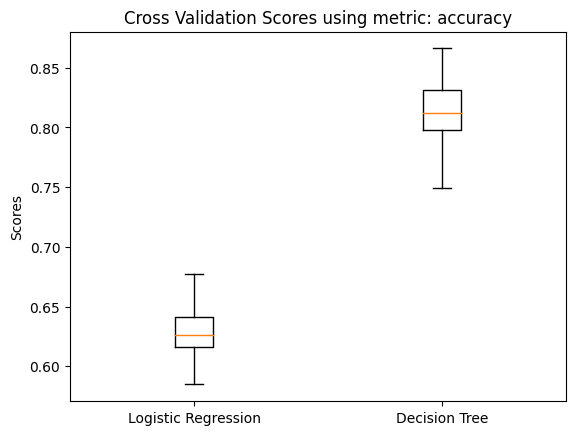

In [10]:
# Create a boxplot to visualize cross validation scores
ml_models.visualize_cv_score(lr_cv_scores[HPscoring], dt_cv_scores[HPscoring], HPscoring)

In [11]:
# Finally, create a DataFrame to store and output the results in a csv file
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Accuracy': [lr_accuracy, dt_accuracy],
    'Precision': [lr_precision, dt_precision],
    'Recall': [lr_recall, dt_recall],
    'F1 Score': [lr_f1, dt_f1],
    'True Negative': [lr_cm[0][0], dt_cm[0][0]],
    'False Positive': [lr_cm[0][1], dt_cm[0][1]],
    'False Negative': [lr_cm[1][0], dt_cm[1][0]],
    'True Positive': [lr_cm[1][1], dt_cm[1][1]]
})
# iterate over the dictionary of cv scores and add them to the data frame
for metric in scoring_metrics:
    results_df['CV Mean Score | {1} | k= {0} folds'.format(HPk_folds, metric.capitalize())] = \
        [lr_cv_scores[metric].mean(), dt_cv_scores[metric].mean()]
    results_df['CV Std Dev Score| {1} | k= {0} folds'.format(HPk_folds, metric.capitalize())] = \
        [lr_cv_scores[metric].std(), dt_cv_scores[metric].std()]

# set the index to the model name
results_df.set_index('Model', inplace=True)
# output the results to a csv file
results_df.to_csv('model_results.csv')